In [98]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import csv
import os
import time
import math
from sortedcontainers import SortedKeyList, SortedDict

In [99]:
# MOB subtractor
subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

In [100]:
# kp and des methods

sift = cv2.xfeatures2d.SIFT_create()
def siftKpAndDes(frame):
    return sift.detectAndCompute(frame,None)

surf = cv2.xfeatures2d.SURF_create()
def surfKpAndDes(frame):
    return surf.detectAndCompute(frame,None)

star = cv2.xfeatures2d.StarDetector_create()
def fastKp(frame):
    return star.detect(frame,None)

brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
def briefDes(frame, kps):
    return brief.compute(frame, kps)

orb = cv2.ORB_create()
def orbKpAndDes(frame):
    return orb.detectAndCompute(frame,None)

In [101]:
# matcher methods

FLANN_INDEX_KDTREE = 1
FLANN_KDTREES = 5

FLANN_INDEX_LSH = 6
TABLE_NUMBER = 6 #12
KEY_SIZE = 12 #20
MULTI_PROBE_LEVEL = 1 #2
SEARCH_CHECKS = 50

#BF matching
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING)
bf_sift = cv2.BFMatcher()
def bfMatcher(des1, des2, feature_type = 'SIFT', ratio = 0.7):

    if feature_type is 'ORB': 
        matches = bf_orb.knnMatch(des1,des2,k=2)
    else:
        matches = bf_sift.knnMatch(des1, des2, k=2)
    # filter using ratio
    good = []
    for pair in matches:
        try:
            m,n = pair
            if m.distance < ratio*n.distance:
                good.append(m)
        except ValueError:
            print('Missing Match pair!')
            good.append(pair)
            pass
    return good, matches


#FLANN-based
search_params = dict(checks = SEARCH_CHECKS)
flann_orb = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_LSH,
                   table_number = TABLE_NUMBER,
                   key_size = KEY_SIZE,
                   multi_probe_level = MULTI_PROBE_LEVEL),
                   search_params)
flann_sift = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_KDTREE, trees = FLANN_KDTREES), 
                                   search_params )
def flannMatcher(des1, des2, feature_type = 'SIFT', ratio=0.7):
    
    if feature_type is 'ORB': 
        matches = flann_orb.knnMatch(des1, des2, k=2)
    else:
        matches = flann_sift.knnMatch(des1, des2, k=2)
    # filter using ratio
    good = []
    for pair in matches:
        try:
            m,n = pair
            if m.distance < ratio*n.distance:
                good.append(m)
        except ValueError:
            print('Missing Match pair!')
            good.append(pair)
            pass
    return good, matches
        

In [102]:
# intersection of two segments given their endpoints
# This code is contributed by Ansh Riyal 

# Hash, String, and comparison definitions provided by Eric Zeng
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y
        self.key = x * 1000 + y * 1000
        
    def __eq__(self, other):
        return (self.x == other.x) and (self.y == other.y)
        
    def __lt__(self, other):
        return self.x < other.x or (self.x == other.x and self.y < other.y)
    
    def __str__(self):
        return "Point(" + str(self.x).zfill(5) + ", " + str(self.y).zfill(5) + ")"

    def __hash__(self):
        return hash(str(self.x) + ',' + str(self.y))
        
  
# Given three colinear points p, q, r, the function checks if  
# point q lies on line segment 'pr'  
def onSegment(p, q, r): 
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and 
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))): 
        return True
    return False
  
def orientation(p, q, r): 
    # to find the orientation of an ordered triplet (p,q,r) 
    # function returns the following values: 
    # 0 : Colinear points 
    # 1 : Clockwise points 
    # 2 : Counterclockwise 
      
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/  
    # for details of below formula.  
      
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y)) 
    if (val > 0): 
          
        # Clockwise orientation 
        return 1
    elif (val < 0): 
          
        # Counterclockwise orientation 
        return 2
    else: 
          
        # Colinear orientation 
        return 0
  
# the main function that returns true if  
# the line segment 'p1q1' and 'p2q2' intersect. 
def doIntersect(p1,q1,p2,q2): 
      
    # Find the 4 orientations required for  
    # the general and special cases 
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    o4 = orientation(p2, q2, q1) 
  
    # General case 
    if ((o1 != o2) and (o3 != o4)): 
        return True
  
    # Special Cases 
  
    # p1 , q1 and p2 are colinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, p2, q1)): 
        return True
  
    # p1 , q1 and q2 are colinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q2, q1)): 
        return True
  
    # p2 , q2 and p1 are colinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, p1, q2)): 
        return True
  
    # p2 , q2 and q1 are colinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q1, q2)): 
        return True
  
    # If none of the cases 
    return False


In [103]:
# Line class by Eric Zeng
class Line:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        self.key = str(p.y).zfill(5) + str(q.y).zfill(5) # lines should be sorted by the y-coors
    
    def __eq__(self, other):
        return (self.p is other.p and self.q is other.q)
    
    def __lt__(self, other):
        return self.p < other.p
    
    def __str__(self):
        return "Line[" + str(self.p).zfill(5) + "-" + str(self.q).zfill(5) + "]"
    
    def __hash__(self):
        return hash(str(self.p) + '-' + str(self.q))
    
# Evaluates if two lines share any endpoints    
def endsCoincident(p1, p2):
#     print("COINCIDENT EP TEST")
#     print(p1.p)
#     print(p1.q)
#     print(p2.p)
#     print(p2.q)
#     print(p1.p == p2.p)
#     print(p1.p == p2.q)
#     print(p1.q == p2.p)
#     print(p1.q == p2.q)
    return (p1.p == p2.p) or (p1.p == p2.q) or (p1.q == p2.p) or (p1.q == p2.q)

# assumes pts are 4 points creating a closed quad
# electing to use list instead of BST or other varients since n=4 (finite, known, and very small)
# This implementation was written by Eric Zeng
def checkSimplePolygon(pts):
    print('INTERSECTION CHECK')
#     print(pts)

    # create 4 segments
    # sort the endpoints in each segment to have the smaller x value be first
    segs = [
            sorted([Point(int(pts[0][0][0] + 10000), int(pts[0][0][1] + 10000)), 
                    Point(int(pts[1][0][0] + 10000), int(pts[1][0][1] + 10000))]), 
            sorted([Point(int(pts[1][0][0] + 10000), int(pts[1][0][1] + 10000)), 
                    Point(int(pts[2][0][0] + 10000), int(pts[2][0][1] + 10000))]),
            sorted([Point(int(pts[2][0][0] + 10000), int(pts[2][0][1] + 10000)), 
                    Point(int(pts[3][0][0] + 10000), int(pts[3][0][1] + 10000))]),
            sorted([Point(int(pts[3][0][0] + 10000), int(pts[3][0][1] + 10000)), 
                    Point(int(pts[0][0][0] + 10000), int(pts[0][0][1] + 10000))])
           ]
    # sort all segments against each other using the starting endpoint's x value
    segs = sorted(segs, key = lambda x: x[0])
#     [print(str(s[0]) + ', ' + str(s[1])) for s in segs]
    segs = [Line(s[0], s[1]) for s in segs] # covert sublists to lines
    
    # init event queue, marking {"Adds" and "Exit" endpoints -> Line} mappings
    eventq = SortedDict()
    for s in segs:
        left = str(s.p) + 'A'
        right = str(s.q) + 'E'
        if (left not in eventq):
            eventq.update({left: list()})
        if (right not in eventq):
            eventq.update({right: list()})
            
        eventq.get(left).append(s)
        eventq.get(right).append(s)
    
#     print("EVENT QUEUE ORDER: ")
#     [print(a) for a in eventq]

    # init sweep line
    sl = SortedKeyList([], key=lambda x: x.key)
    for e in eventq:
#         print(e)
#         print('targets: ' + ",".join(str(line) for line in eventq[e]))
#         print('SL: ' + ",".join(str(line) for line in sl))
        if e[-1] is 'A':
#             print('ADDS')
            for line in eventq[e]:
                sl.add(line)
#                 print(line)
                try: 
#                     print('above')
                    above = sl[sl.index(line) + 1]
                    if (not endsCoincident(above, line)) and doIntersect(above.p, above.q, line.p, line.q):
#                         print('above FALSE')
                        return False
                except IndexError:
#                     print('above index error')
                    pass # missing above
                try: 
#                     print('below')
                    below = sl[sl.index(line) - 1]
                    if (not endsCoincident(below, line)) and doIntersect(below.p, below.q, line.p, line.q):
#                         print('below FALSE')
                        return False
                except IndexError:
#                     print('below index error')
                    pass # missing above
        else: # e[0] is 'E'
#             print('REMOVES')
            for line in eventq[e]:
                # check above and below intersections if not conincident
#                 print(line)
                try:
#                     print('both')
                    above = sl[sl.index(line) + 1]
                    below = sl[sl.index(line) - 1]
                    if (not endsCoincident(above, below)) and doIntersect(above.p, above.q, below.p, below.q):
#                         print('both FALSE')
                        return False
                except IndexError:
#                     print('both index error')
                    pass # missing either/both line above or below in SL, no need for additional check
                 
                # once check is done, discard this line from the SL
                
                sl.remove(line)

#         [print(l) for l in sl]
#         print()
    print('PASSED')
    return True

# testpoly = [[[30, 30]], [[56, 56]], [[52, 32]], [[32, 52]] ]

# test = cv2.polylines(img1,[np.int32(testpoly)],True,(0,255,0),3, cv2.LINE_AA)  
# plt.figure(figsize=(20,20))
# plt.imshow(test)

# checkSimplePolygon(testpoly)

In [104]:
# python3 program to evaluate 
# area of a polygon using 
# shoelace formula, clockwise in opencv coordinate system
# 
# NOTE: assumes polygon is simple and closed (non-intersecting)
# please check before simple property before running
# (X[i], Y[i]) are coordinates of i'th point. 
# This code is contributed by Smitha Dinesh Semwal 
# https://www.geeksforgeeks.org/area-of-a-polygon-with-given-n-ordered-vertices/
def shoelace(points): 
    
    #transform list of Point object to two lists of X and Y coordinates
    X = []
    Y = []
    for p in points:
        X.append(p.x)
        Y.append(p.y)
  
    # Initialze area 
    area = 0.0
  
    # Calculate value of shoelace formula 
    j = len(points) - 1
    for i in range(0,len(points)): 
        area += (X[j] + X[i]) * (Y[j] - Y[i]) 
        j = i   # j is previous vertex to i 
      
  
    # Return absolute value 
    return abs(area / 2.0)

In [105]:
# Simple Polygon Area comparison utilizing shoelace above
def checkArea(pts, total_area, min_area):
    points = [
        Point(pts[0][0][0], pts[0][0][1]),
        Point(pts[1][0][0], pts[1][0][1]),
        Point(pts[2][0][0], pts[2][0][1]),
        Point(pts[3][0][0], pts[3][0][1]),
    ]
    area = shoelace(points)
    ratio = area / total_area
    return (ratio < 1.0 and ratio > min_area), ratio
    

In [106]:
# Container class to represent a positive match to be saved in our CSV output
class PositiveMatch:
    def __init__(self, img, name, area, smallest_angle, largest_angle, cwf):
        self.img = img
        self.name = name
        self.area = area
        self.smallest_angle = smallest_angle
        self.largest_angle = largest_angle
        self.cwf = cwf

In [107]:
# Script to output results to CSV
def outputCSV(positives, errors, query, video, output_dir, chain, feature_ext, matcher,
               frame_interval, ratio, min_matches, fps,
                min_area, allow_intersections, min_angle, max_angle):
    print("Analysis finished!")
    # TODO: post-processing of CSV and image files
    # TOTO: consider saving dict of positives alongside csv file to allow for futher analytics
    # TODO: write out detailed Errors too
    with open(os.path.join(output_dir,'results.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['SUMMARY OF PARAMS'])
        writer.writerow(['Query Image', 'Video', 'Chain Length', 'Feature Extractor', 'Matcher', 
                         'Frame Interval', 'Pass Ratio', 'Match Thresh',
                        'Min Area', 'Filter Intersections', 'Min Angle', 'Max Angle'])
        writer.writerow([query, video, chain, feature_ext, matcher, frame_interval, ratio, min_matches,
                        min_area, not allow_intersections, min_angle, max_angle])
        writer.writerow(['MATCHES'])
        writer.writerow(['Frame Num', 'Img Name', 'Area','Min Angle', 'Max Angle', 'Chain Weight Factor'])
        for match in positives.items():
            writer.writerow([match[0], match[1].name, match[1].area, match[1].smallest_angle, match[1].largest_angle,
                             match[1].cwf])
            # TODO: more metadata later; consider making a PositiveMatch class as a container object
        writer.writerow(['ERRORS'])
        for err in errors:
            writer.writerow([err])
            
# Adds on-screen display information to the target img
def addOSD(tgt, n_pos, chain_n, frame_n, delta):
    cv2.putText(tgt, "T.Count: " + str(n_pos), (2,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(tgt, "Pos.Chain: " + str(chain_n), (2,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(tgt, "Frame.Num: " + str(frame_n) + delta, (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

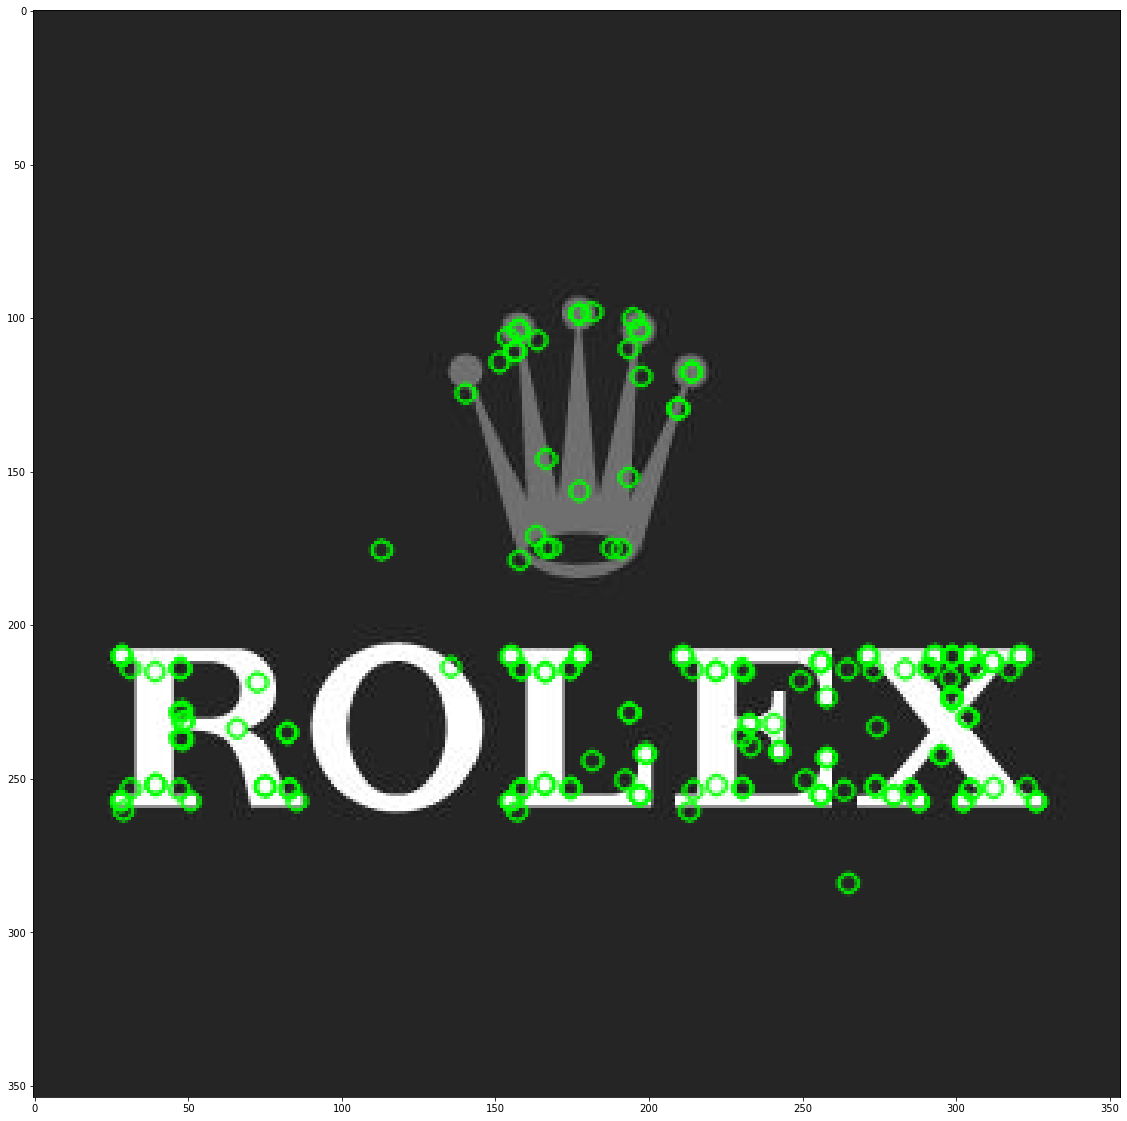

171


In [108]:
# preprocess kp/des for query image(s)

img1 = cv2.imread('logos/rolex.jpg',0) # queryImage
# find the keypoints and descriptors
kp1, des1 = siftKpAndDes(img1)

img1kps = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
plt.figure(figsize=(20,20))
plt.imshow(img1kps), plt.show()

print(len(kp1))

In [115]:
# encoding params for quality when saving sample jpeg screenshots
encoding_params = [int(cv2.IMWRITE_JPEG_QUALITY), 10]

def runMatching(query, video, output_dir="outputs", chain = 3, feature_ext = 'ORB', matcher = 'FLANN',
               frame_interval = 1, ratio = 0.7, min_matches = 15, fps = 30,
                min_area='0.1', allow_intersections = False, min_angle = 30, max_angle = 120):
    positives = dict() # dict of frame numbers of positive indentifications
    n_pos = 0 # total count of positives
    errors = [] # list of error frames to analyze later (hopefully should be empty!)
    
    cap = cv2.VideoCapture(video)
    img_chain = [] # list of past images in the current running chain of positive frames, up to the chain parameter
    
    # preprocess kp/des for query image(s)
    img1 = cv2.imread(query, 0)
    if feature_ext is 'ORB':     
        kp1, des1 = orbKpAndDes(img1)
    elif feature_ext is 'SIFT':
        kp1, des1 = siftKpAndDes(img1)
    else:
        # no features or matching
        kp1, des1 = [], []
    
    
    # frame number tracker
    frame_n = 0
    
    # start time for running speed measure
    start_t = time.process_time()
    delta = ''
    
    while(True):
        for i in range(frame_interval - 1):
            #skip i number of frames
            cap.grab()

        # Capture frame-by-frame and covert to grayscale
        ret, frame = cap.read()
        if not ret:
            break # exit when done
            
        frame_n += 1 # ret is True, frame found, continue processing
        
        # running speed display (delta is % speed of realtime according to input fps and frame interval)
        if frame_n % fps is 0:
            end_t = time.process_time()
            delta = int((100.0 * frame_interval) / (end_t - start_t))
            delta = " (" + str(delta) + "%)"
            start_t = time.process_time()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # TESTING: MOG2 background subtractor mask
#         mask = subtractor.apply(gray, masked, 0.999)
#         masked = cv2.bitwise_and(gray, masked)
#         kp2, des2 = siftKpAndDes(masked)

#         # TESTING: Equalize historgram to incrase contrast (probably for ORB)
#         eh = cv2.equalizeHist(gray)
#         kp2, des2 = siftKpAndDes(eh)

#         # TESTING: Blurring with various LPFs
#         blurred = cv2.bilateralFilter(gray,9,75,75)
#         kp2, des2 = siftKpAndDes(blurred)

        # DEFAULT: find the keypoints and descriptors
        if feature_ext is 'ORB':     
            kp2, des2 = orbKpAndDes(gray)
        elif feature_ext is 'SIFT':
            kp2, des2 = siftKpAndDes(gray)
        else:
            # no features or matching
            cv2.putText(gray, "Frame.Num: " + str(frame_n) + delta, (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv2.imshow('frame', gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            continue


        # list of good matches (need to init to empty for debug mode)
        good = []
        
        # check flags
        areaCheck = False
        intersectionCheck = False
        try:
            if matcher is 'FLANN':
                good, matches = flannMatcher(des1, des2, feature_type=feature_ext, ratio=ratio)
            elif matcher is 'BF':
                good, matches = bfMatcher(des1, des2, feature_type=feature_ext, ratio=ratio)
            else:
                # DEBUGGING: show only target image kps, no matching run
                img3 = cv2.drawKeypoints(gray, kp2, None, color=(0,255,0), flags=0)
                cv2.putText(img3, "Frame.Num: " + str(frame_n) + delta, (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                cv2.imshow('frame',img3)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                continue
                

            if len(good) > min_matches:
                print(len(good))
                src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

                if M is None:
                    # if homography matrix is empty
                    print("Empty homography matrix")
                    img3 = gray # display image without any lines
                else:
#                     print(M)
                    matchesMask = mask.ravel().tolist()
                    h,w = img1.shape
                    pts = np.float32([ [0,0],[w-1,0],[w-1,h-1],[0,h-1] ]).reshape(-1,1,2) # cw direction
                    dst = cv2.perspectiveTransform(pts,M)
                
                    # TODO: analyze shpae of dst, checking it is reasonable
                    flat = [coor for pt in dst for c in pt for coor in c] # mark as bad if coordinates are extreme (abs >= 10,000)
                    if not any([coor >= 10000 or coor <= -10000 for coor in flat]):
                        total_area = gray.shape[0] * gray.shape[1]
                        areaCheck, homography_area = checkArea(dst, total_area, min_area) if min_area > 0 else (True, None) # auto pass if min_area is 0
                        if areaCheck: # only bother checking intersections if area is OK
                            intersectionCheck = checkSimplePolygon(dst) if not allow_intersections else True

                    # covert to color so homography line can be shown
                    color = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
                    if (not areaCheck):
                        img3 = cv2.polylines(color,[np.int32(dst)],True,(0,255,255),3, cv2.LINE_AA)             
                    elif (not intersectionCheck):
                        img3 = cv2.polylines(color,[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)                     
                    else:
                        img3 = cv2.polylines(color,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

            else:
                print( "Not enough matches are found - {}/{}".format(len(good), min_matches) )
                matchesMask = None
                img3 = gray # display image without any lines

#             draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                                singlePointColor = None,
#                                matchesMask = matchesMask, # draw only inliers
#                                flags = 2)
#             img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

#             # Display the resulting frame
#             cv2.imshow('frame',gray)
            
        except cv2.error as e:
            print('Matching Error! Recording and skipping this frame...')
            img3 = gray # display image without any lines
            print(e)
            errors.append(e)

        #  saving samples positives images
        if len(good) > min_matches and M is not None and areaCheck and intersectionCheck:
            img_name = 'frame%d.jpg' % frame_n
            print(homography_area)
            pm = PositiveMatch(img3, img_name, homography_area, None, None, 1)
            img_chain.append(pm) # add this image to the current continuous chain of positive frames
            if len(img_chain) is chain:
                for i,img_in_chain in enumerate(img_chain):
                    n_pos += 1
                    addOSD(img3, n_pos, len(img_chain), frame_n, delta) if i is chain - 1 else None
                    cv2.imwrite(os.path.join(output_dir, img_in_chain.name), img_in_chain.img, encoding_params) # write with compression param as specified up top
                    positives[frame_n - chain + 1 + i] = img_in_chain
                    print('RECORDED: ' + str(img_in_chain.name))
            elif len(img_chain) > chain:
                n_pos += 1
                addOSD(img3, n_pos, len(img_chain), frame_n, delta)
                cv2.imwrite(os.path.join(output_dir, img_name), img3, encoding_params) # write with compression param as specified up top
                positives[frame_n] = pm
                print('RECORDED: ' + str(img_name))
                
                # TODO: save only the single median image in each group of 5?
#             if len(img_chain) % chain is 0:

            else:
                addOSD(img3, n_pos, len(img_chain), frame_n, delta)
        
        else:
            img_chain = [] # if negative, then clear chain
            addOSD(img3, n_pos, len(img_chain), frame_n, delta)
            
        

        cv2.imshow('frame',img3)

        if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        elif cv2.waitKey(1) & 0xFF == ord('p'):
            while True:
                if cv2.waitKey(1) & 0xFF == ord('o'):
                     break

                            
               
                    

    # When everything done, release the capture
    cap.release()
    
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    # write outputs
    outputCSV(positives, errors, query, video, output_dir, chain, feature_ext, matcher,
               frame_interval, ratio, min_matches, fps,
                min_area, allow_intersections, min_angle, max_angle)
    
    return positives, n_pos, errors

In [116]:
# runner
# TODO: make all params specified here

FRAME_INTERVAL = 2 # 1 means no frame skips
MIN_MATCH_COUNT =  10 # RULE: >10% of keypoints in query image? -> work well only fort scale-invarient (SIFT)
RATIO = 0.7 # lowered from 0.7 to derease sensitivity
MIN_AREA = 0.01 # 0 to disable area checking

runMatching('logos/rolex.jpg', 'videos/15brazil-5min.mp4', output_dir='outputs', chain=3,
            feature_ext = 'ORB', matcher='FLANN',
            frame_interval=FRAME_INTERVAL, ratio=RATIO, min_matches=MIN_MATCH_COUNT, fps=50, 
            min_area=MIN_AREA,  allow_intersections=False, min_angle=30, max_angle= 120)


Not enough matches are found - 3/10
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 7/10
Not enough matches are found - 6/10
Missing Match pair!
Not enough matches are found - 3/10
Not enough matches are found - 2/10
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 2/10
Missing Match pair!
Not enough matches are found - 2/10
Missing Match pair!
Not enough matches are found - 2/10
Not enough matches are found - 4/10
Not enough matches are found - 0/10
Not enough matches are found - 0/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 2/10
Not enough matches are found - 3/10
Not enough matches are found - 5/10
Not enough matches are found - 1/10
Not enough matches are found - 2/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 5/10


Not enough matches are found - 4/10
Not enough matches are found - 0/10
Missing Match pair!
Not enough matches are found - 3/10
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 3/10
Not enough matches are found - 2/10
Not enough matches are found - 3/10
Not enough matches are found - 2/10
11
Not enough matches are found - 0/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 10/10
Not enough matches are found - 9/10
Not enough matches are found - 6/10
Not enough matches are found - 6/10
Not enough matches are found - 8/10
Not enough matches are found - 4/10
Not enough matches are found - 6/10
Not enough matches are found - 10/10
Not enough matches are found - 6/10
Not enough matches are found - 2/10
Not enough matches are found - 8/10
Not enough matches are found - 8/10
Not enough matches are found - 5/10
Not enough matches are found - 8/10
14
Not enough matches are found - 7/10
Not enough match

Not enough matches are found - 1/10
Not enough matches are found - 0/10
Not enough matches are found - 8/10
Not enough matches are found - 5/10
Not enough matches are found - 2/10
Not enough matches are found - 9/10
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 8/10
Not enough matches are found - 7/10
Not enough matches are found - 3/10
Missing Match pair!
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Missing Match pair!
Not enough matches are found - 5/10
Not enough matches are found - 9/10
16
INTERSECTION CHECK
PASSED
0.2669723277621799
Missing Match pair!
Not enough matches are found - 5/10
Not enough matches are found - 6/10
Not enough matches are found - 5/10
Missing Match pair!
17
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 8/10
Not enough matches are found - 7/10
Not enough matches are found - 4/10
Not enough matches ar

Missing Match pair!
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 2/10
Not enough matches are found - 3/10
Not enough matches are found - 10/10
Missing Match pair!
Not enough matches are found - 5/10
Missing Match pair!
Not enough matches are found - 9/10
Not enough matches are found - 1/10
Not enough matches are found - 4/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 10/10
Not enough matches are found - 6/10
Missing Match pair!
Not enough matches are found - 1/10
Not enough matches are found - 2/10
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 8/10
Not enough matches are found - 5/10
Not enough matches are found - 6/10
Missing Match pair!
Not enough matches are found - 7/10
Not enough matches are found - 2/10
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Not enough mat

Not enough matches are found - 8/10
Not enough matches are found - 4/10
Not enough matches are found - 3/10
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Not enough matches are found - 6/10
Not enough matches are found - 6/10
12
Not enough matches are found - 5/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 10/10
Not enough matches are found - 5/10
Not enough matches are found - 7/10
Not enough matches are found - 10/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 4/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 1/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Missing Match pair!
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 2/10
Not enough matches are found - 6/10
Missing Match pair!
Missing Match pair!

Missing Match pair!
Not enough matches are found - 2/10
Missing Match pair!
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 7/10
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 6/10
Not enough matches are found - 6/10
11
Not enough matches are found - 4/10
Not enough matches are found - 1/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 1/10
Not enough matches are found - 5/10
Not enough matches are found - 9/10
Missing Match pair!
11
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 9/10
Not enough matches are found - 8/10
Not enough matches are found - 5/10
Not enough matches are found - 5/10
Not enough matches are found - 10/10
Not enough matches are found - 7/10
Not enough matches are found - 8/10
12
13
Not enough matches are found - 10/10
Not en

Not enough matches are found - 5/10
Not enough matches are found - 5/10
Not enough matches are found - 0/10
Not enough matches are found - 5/10
Not enough matches are found - 4/10
Not enough matches are found - 5/10
Not enough matches are found - 4/10
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Not enough matches are found - 7/10
Not enough matches are found - 4/10
Not enough matches are found - 7/10
Not enough matches are found - 7/10
Not enough matches are found - 6/10
Not enough matches are found - 5/10
Not enough matches are found - 6/10
Not enough matches are found - 7/10
Not enough matches are found - 10/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Not enough matches are found - 6/10
Not enough matches are found - 4/10
Not enough matches are foun

Not enough matches are found - 6/10
Not enough matches are found - 4/10
Not enough matches are found - 9/10
Not enough matches are found - 4/10
Not enough matches are found - 6/10
Not enough matches are found - 6/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 9/10
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Not enough matches are found - 9/10
Not enough matches are found - 10/10
Not enough matches are found - 7/10
Not enough matches are found - 2/10
11
Not enough matches are found - 8/10
Not enough matches are found - 6/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 6/10
Not enough matches are found - 6/10
Not enough matches are found - 3/10
Not enough matches are found - 6/10
Not enough matches are found - 5/10
Not enough matches are found - 7/10
Not enough matches are f

Not enough matches are found - 5/10
Not enough matches are found - 6/10
Not enough matches are found - 8/10
Not enough matches are found - 9/10
Not enough matches are found - 8/10
Missing Match pair!
Not enough matches are found - 10/10
Not enough matches are found - 8/10
Not enough matches are found - 7/10
Missing Match pair!
Not enough matches are found - 5/10
Not enough matches are found - 7/10
Not enough matches are found - 10/10
Not enough matches are found - 9/10
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 7/10
Not enough matches are found - 7/10
Not enough matches are found - 4/10
Not enough matches are found - 8/10
Not enough matches are found - 4/10
Not enough matches are found - 10/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 7/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 5/10
Not enough matches are found - 4/10
N

Missing Match pair!
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Not enough matches are found - 1/10
Missing Match pair!
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 0/10
Not enough matches are found - 4/10
Not enough matches are found - 2/10
Not enough matches are found - 4/10
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 1/10
Not enough matches are found - 2/10
Not enough matches are found - 4/10
Not enough matches are found - 4/10
Not enough matches are found - 2/10
Not enough matches are found - 8/10
Not enough matches are found - 6/10
Not enough matches are found - 6/10
Not enough matches are found - 2/10
Not enough matches are found - 1/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 3/10
Not enough matches a

Not enough matches are found - 5/10
Not enough matches are found - 9/10
Not enough matches are found - 2/10
Not enough matches are found - 5/10
Not enough matches are found - 5/10
11
Not enough matches are found - 2/10
Not enough matches are found - 8/10
15
11
Not enough matches are found - 5/10
Not enough matches are found - 3/10
11
Not enough matches are found - 10/10
Not enough matches are found - 7/10
Not enough matches are found - 6/10
Not enough matches are found - 7/10
Not enough matches are found - 9/10
Not enough matches are found - 5/10
Not enough matches are found - 1/10
Not enough matches are found - 5/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 1/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Missing Match pair!
Not enough matches are found - 1/10
Not enough matches are found - 

Not enough matches are found - 2/10
Not enough matches are found - 4/10
Not enough matches are found - 3/10
Missing Match pair!
Missing Match pair!
Not enough matches are found - 9/10
Not enough matches are found - 3/10
Not enough matches are found - 4/10
Not enough matches are found - 6/10
Not enough matches are found - 2/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 5/10
Missing Match pair!
Not enough matches are found - 8/10
Not enough matches are found - 5/10
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 2/10
Not enough matches are found - 0/10
Not enough matches are found - 1/10
Not enough matches are found - 5/10
Not enough matches are found - 8/10
Not enough matches are found - 4/10
Not enough matches are found - 5/10
Not enough matches are found - 7/10
Not enough matches are found - 5/10
Not enough matches are found - 2/10
Not enough matches are found - 2/10
Not enough matches a

Not enough matches are found - 5/10
Not enough matches are found - 2/10
Not enough matches are found - 7/10
Not enough matches are found - 8/10
Missing Match pair!
Not enough matches are found - 7/10
Not enough matches are found - 1/10
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 4/10
Missing Match pair!
Not enough matches are found - 4/10
Not enough matches are found - 4/10
Not enough matches are found - 4/10
Not enough matches are found - 1/10
Not enough matches are found - 4/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 3/10
Not enough matches are found - 1/10
Not enough matches are found - 4/10
Not enough matches are found - 5/10
Not enough matches are found - 3/10
Not enough matches are found - 7/10
Not enough matches are found - 6/10
Not enough matches are found - 2/10
Not enough matches are found - 6/10
Not enough matches are found - 5/10
Not enough matches are found - 4/10
Not 

UnboundLocalError: local variable 'm' referenced before assignment